**Table of contents**<a id='toc0_'></a>    
- [Dataset & Libraries](#toc1_)    
- [Data Cleaning](#toc2_)    
- [Modeling](#toc3_)    
    - [Grid Search](#toc3_1_1_)    
  - [FunkSVD Model](#toc3_2_)    
  - [Predictions & Accuracy](#toc3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

I will now develop a Memory-Based Recommendation system to predict the rating for each recipe based on the historical ratings given. Logic here is that, recipes with similar ratings could get similar rating by a user who has rated one of the two. 

# <a id='toc1_'></a>[Dataset & Libraries](#toc0_)

In [4]:
#lbraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [5]:
#funkSVD libraries
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [52]:
#datset
ratings= pd.read_csv('C:/Users/e312995/OneDrive - WESCO DISTRIBUTION/documents/PERSONAL/BRAINSTATION/CAPSTONE/Datasets/reviews.csv')
ratings.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
0,2,992,2008,gayg msft,5,better than any you can get at a restaurant!,2000-01-25T21:44:00Z,2000-01-25T21:44:00Z
1,7,4384,1634,Bill Hilbrich,4,"I cut back on the mayo, and made up the differ...",2001-10-17T16:49:59Z,2001-10-17T16:49:59Z
2,9,4523,2046,Gay Gilmore ckpt,2,i think i did something wrong because i could ...,2000-02-25T09:00:00Z,2000-02-25T09:00:00Z
3,13,7435,1773,Malarkey Test,5,easily the best i have ever had. juicy flavor...,2000-03-13T21:15:00Z,2000-03-13T21:15:00Z
4,14,44,2085,Tony Small,5,An excellent dish.,2000-03-28T12:51:00Z,2000-03-28T12:51:00Z


In [53]:
#shape
ratings.shape

(1401982, 8)

# <a id='toc2_'></a>[Data Cleaning](#toc0_)

I will quickly check whether the datset contains any null or duplicates.

In [54]:
#null values as a %
ratings.isna().sum()/ratings.shape[0]*100

ReviewId         0.000000
RecipeId         0.000000
AuthorId         0.000000
AuthorName       0.000000
Rating           0.000000
Review           0.015264
DateSubmitted    0.000000
DateModified     0.000000
dtype: float64

Given that there are no null values in  the rating column, we will not drop any data here. Null % of the review text data is ~0%.

In [55]:
#duplicated data
ratings.duplicated().sum()

0

No duplicate values as well

In [56]:
#sorting the ratiings by the Author and Recipe IDs
ratings_ = ratings.sort_values(by=['AuthorId', 'RecipeId'])
ratings_.head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
145848,156476,2137,1533,Dancer,5,OUTSTANDING was the only comments my guests ma...,2005-02-27T09:30:26Z,2005-02-27T09:30:26Z
62702,69050,2585,1533,Dancer,1,Sorry this wasn't what I expected. I love chic...,2003-09-26T19:27:03Z,2003-09-26T19:27:03Z
154718,165873,4213,1533,Dancer,5,"This is the best I have tasted, I have made it...",2005-04-10T09:43:57Z,2005-04-10T09:43:57Z
18652,22342,8857,1533,Dancer,5,"I'm Dancing around my kitchen, finally I have ...",2002-08-23T17:58:39Z,2002-08-23T17:58:39Z
142105,152525,10332,1533,Dancer,5,Hi Bergy..Yesterday was a little rushed for me...,2005-02-09T08:03:54Z,2005-02-09T08:03:54Z


In [57]:
#checking the values in the rating column
ratings.groupby('Rating')['RecipeId'].count()

Rating
0      76248
1      16559
2      17597
3      50279
4     229217
5    1012082
Name: RecipeId, dtype: int64

It is visible that 72% of the ratings are of 5 and 16% of 4 constituting to 88% of high ratings in the dataset and we have 76k recipes with zero ratings. We will check them deeper. 

In [60]:
ratings[ratings['Rating']==0].head()

,ReviewId,RecipeId,AuthorId,AuthorName,Rating,Review,DateSubmitted,DateModified
7,21,148,2156,Darlene Blythe,0,Would someone please check the Nutrition Facts...,2000-06-02T10:01:00Z,2000-06-02T10:01:00Z
34,73,2502,2848,Jeff Lucco,0,Unusual name for a recipe that has no pumpkin ...,2000-10-17T15:03:25Z,2000-10-17T15:03:25Z
47,91,4165,3166,Debbie Lawton,0,I thought Chicken Cacciatore had peppers. If i...,2000-11-04T09:06:30Z,2000-11-04T09:06:30Z
56,109,2505,3287,Amy Hayes,0,Terrible directions. Doesn't say how to make t...,2000-11-12T00:13:31Z,2000-11-12T00:13:31Z
76,138,4048,3504,Christina Branscm,0,makes 2- 9inch pies or 1 deep dish pie,2000-11-23T13:00:07Z,2000-11-23T13:00:07Z


We cannot conclude whether they are not rated with this data. It could be low rated recipes. 

# <a id='toc3_'></a>[Modeling](#toc0_)

I will use FunkSVD Memory Based recommendations here. 

In [61]:
#loading data as a special Dataset object
my_dataset = Dataset.load_from_df(ratings_[['AuthorId', 'RecipeId', 'Rating']], Reader(rating_scale=(1, 5)))


### <a id='toc3_1_1_'></a>[Grid Search](#toc0_)

In [ ]:
#grid search to find the best parameters
param_grid= {
    'n_factors' : [5,10, 15, 20, 25, 30, 40],
    'n_epochs' :[2,3,5,7,9,11],
    'lr_all' : [0.1, 0.05, 0.005],
    'biased': [False]
}

grid_search= GridSearchCV(FunkSVD, param_grid, measures= ['fcp'], cv=3)
grid_search.fit(my_dataset)


I tried using the above code to do a grid search for the train data set, but it returns an error. Couldnt find the resolve. Hence ran it for the full dataset.

I will now check the FCP scores for different n_factors

In [62]:
#train test split
my_train_dataset, my_test_dataset = train_test_split(my_dataset, test_size=0.3)

In [63]:
#model for different n factors 
fcps = []
factors = range(5, 40, 5)
for n_factors in factors:
    my_algorithm_factors = FunkSVD(n_factors=n_factors,
                           n_epochs=5,
                           lr_all=0.005,    # Learning rate for each epoch
                           biased=False,  # forces the algorithm to store all latent information in the matrices
                           verbose=0)

    my_algorithm_factors.fit(my_train_dataset)
    predictions_factors= my_algorithm_factors.test(my_test_dataset)

    FCP_factors= accuracy.fcp(predictions_factors, verbose=5)
    FCP_factors= fcps.append(FCP_factors)
    
  

FCP:  0.6390
FCP:  0.6410
FCP:  0.6394
FCP:  0.6355
FCP:  0.6367
FCP:  0.6323
FCP:  0.6359


In [ ]:
#model for different n factors 
fcps = []
factors = range(5, 40, 5)
for n_factors in factors:
    my_algorithm_factors = FunkSVD(n_factors=n_factors,
                           n_epochs=5,
                           lr_all=0.005,    # Learning rate for each epoch
                           biased=False,  # forces the algorithm to store all latent information in the matrices
                           verbose=0)

    my_algorithm_factors.fit(my_train_dataset)
    predictions_factors= my_algorithm_factors.test(my_test_dataset)

    FCP_factors= accuracy.fcp(predictions_factors, verbose=False)
    fcps.append(FCP_factors)



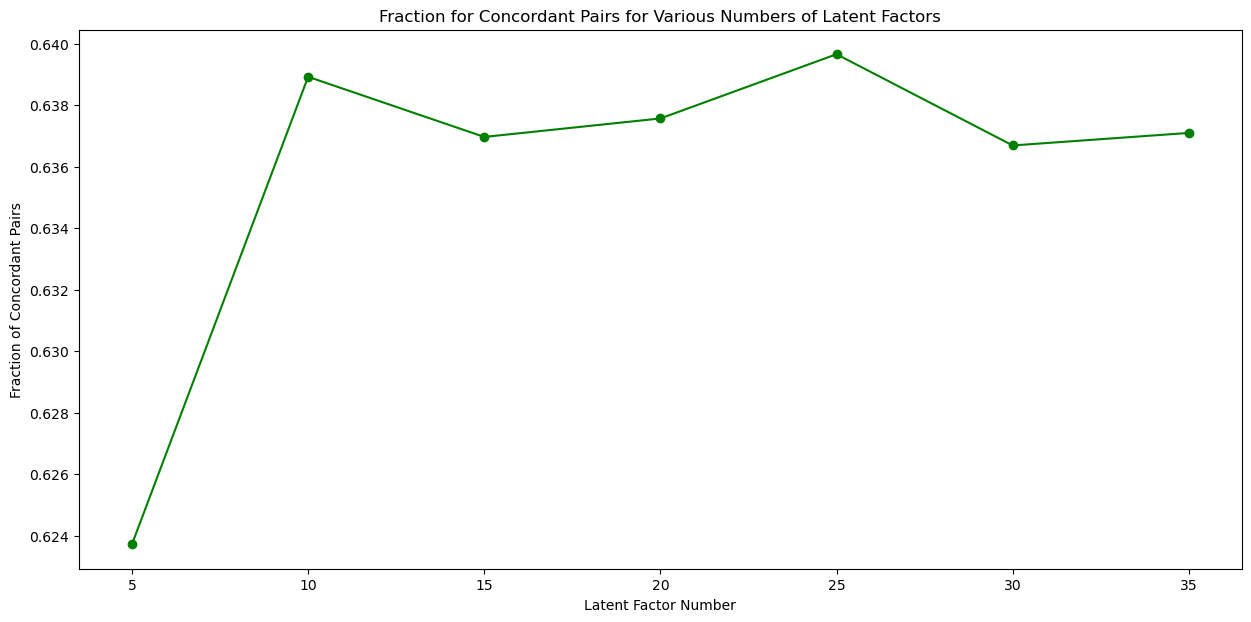

In [67]:
#graph visualisation
plt.figure(figsize=(15, 7))
plt.plot(factors, fcps, color='green', marker= 'o')
plt.xlabel("Latent Factor Number")
plt.ylabel("Fraction of Concordant Pairs")
plt.title("Fraction for Concordant Pairs for Various Numbers of Latent Factors")
plt.show()

Now checking the best parameters

I will now check the FCP scores for different epochs factors

In [68]:
#model for different epochs
fcps = []
epochs = range(1,10,1)
for epoch in epochs:
    my_algorithm_epochs = FunkSVD(n_factors=5,
                           n_epochs=epoch,
                           lr_all=0.005,    # learning rate for each epoch
                           biased=False,  # forces the algorithm to store all latent information in the matrices
                           verbose=0)

    my_algorithm_epochs.fit(my_train_dataset)
    predictions_epochs= my_algorithm_epochs.test(my_test_dataset)

    FCP_epochs= accuracy.fcp(predictions_epochs, verbose=False)
    fcps.append(FCP_epochs)

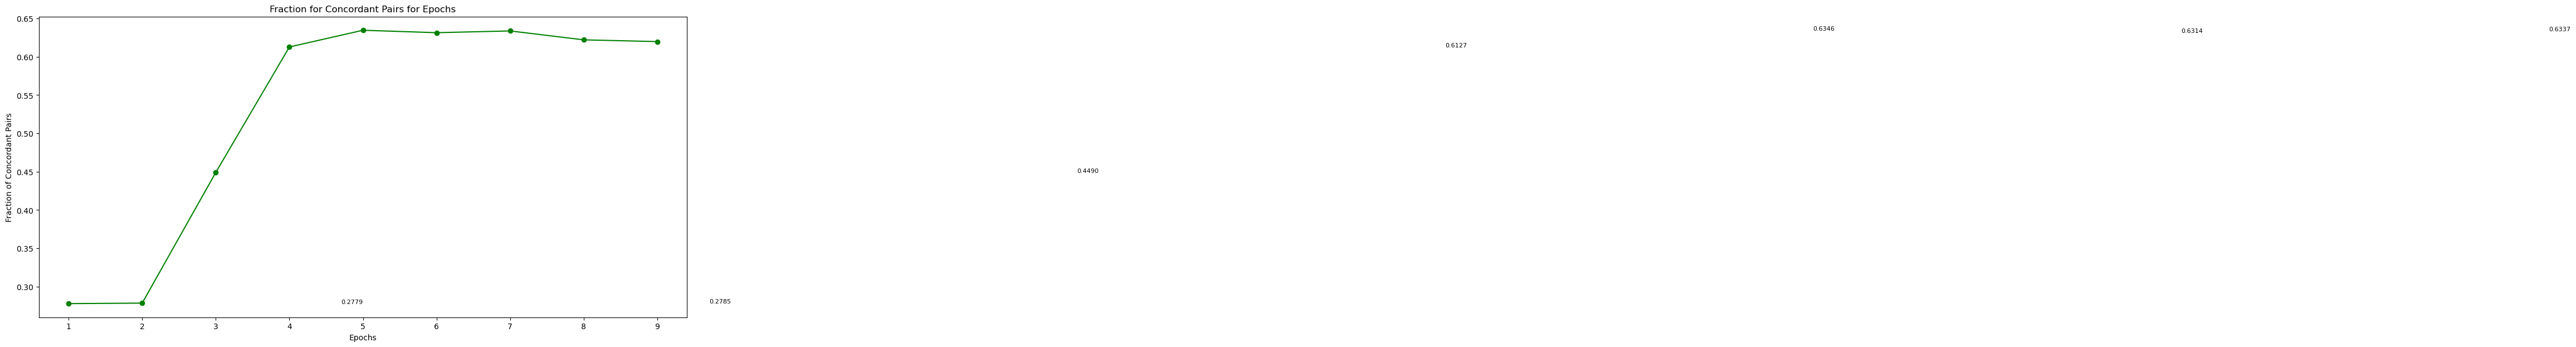

In [69]:
#graph visualisation
plt.figure(figsize=(15, 7))
plt.plot(epochs, fcps, color='green', marker= 'o')

for i in range(len(factors)):
    plt.text(factors[i], fcps[i], "{:.4f}".format(fcps[i]), size=8, ha='right') #plotting the x, y attributes with the y values of the data, size, position
plt.xlabel("Epochs")
plt.ylabel("Fraction of Concordant Pairs")
plt.title("Fraction for Concordant Pairs for Epochs")
plt.show()

Considering above, I will use n_factors=15 and epochs=5 as the hyperparameters

In [17]:
final_model= FunkSVD(n_factors=25,
                           n_epochs=6,
                           lr_all=0.005,    # learning rate for each epoch
                           biased=False,  # forces the algorithm to store all latent information in the matrices
                           verbose=0)

final_model.fit(my_train_dataset)
final_predictions= final_model.test(my_test_dataset)

FCP= accuracy.fcp(final_predictions, verbose=5)
print(FCP)

FCP:  0.6304
0.6304407053926779


Test accuracy is 0.63 which means 63% of the times predictions were accurate.

### Code error

In [21]:
full_train_set= my_dataset.build_full_trainset()
final_model.fit(full_train_set)

In [22]:
full_test_set = full_train_set.build_anti_testset(fill=-1)

MemoryError: 

I cannot run beyond this code even with 0.05% of data. Hence I will develop the predicted ratings based on the the original dataset. 

### Predictions 

In [19]:
test_predictions= final_model.test(my_test_dataset)

It can be seen that test accuracy has improved slightly. I will now load the predictions to a dataframe and check the difference between the predictions & actuals

In [20]:
#adding the predictions to a datframe
predictions_df = pd.DataFrame(test_predictions, columns=['AuthorId',
                                                     'RecipeId',
                                                     'ActualRating',
                                                     'PredictedRating', 
                                                     'Details'])

predictions_df

,AuthorId,RecipeId,ActualRating,PredictedRating,Details
0,48920,236812,5.0,1.000000,{'was_impossible': False}
1,1743422,203473,5.0,1.321894,{'was_impossible': False}
2,1157973,80536,2.0,2.034110,{'was_impossible': False}
3,1800137054,54351,5.0,1.000000,{'was_impossible': False}
4,916089,178370,3.0,1.000000,{'was_impossible': False}
...,...,...,...,...,...
420590,346267,225013,4.0,4.408651,"{'was_impossible': True, 'reason': 'User and i..."
420591,57042,183114,0.0,4.408651,"{'was_impossible': True, 'reason': 'User and i..."
420592,127933,63785,5.0,4.303352,{'was_impossible': False}
420593,646969,37190,4.0,1.000000,{'was_impossible': False}


In [21]:
#checking the difference between the predicted and actual
predictions_df['RatingDiff']= abs(predictions_df['PredictedRating']- predictions_df['ActualRating']) #differences

In [22]:
#checking the best results 
predictions_df.sort_values(by='RatingDiff').head(20) #rating diff zero sample

,AuthorId,RecipeId,ActualRating,PredictedRating,Details,RatingDiff
270375,482376,182455,5.0,5.0,{'was_impossible': False},0.0
275195,780028,63733,5.0,5.0,{'was_impossible': False},0.0
275188,679953,177196,5.0,5.0,{'was_impossible': False},0.0
275184,35140,19135,5.0,5.0,{'was_impossible': False},0.0
275177,119422,95086,5.0,5.0,{'was_impossible': False},0.0
275175,1280189,69173,5.0,5.0,{'was_impossible': False},0.0
275173,130447,12431,5.0,5.0,{'was_impossible': False},0.0
58113,1313898,27159,1.0,1.0,{'was_impossible': False},0.0
275139,133174,83189,5.0,5.0,{'was_impossible': False},0.0
275136,46353,32204,5.0,5.0,{'was_impossible': False},0.0


In [47]:
#checking the worst results 
predictions_df.sort_values(by='RatingDiff').tail(20) #rating diff highest sample

,AuthorId,RecipeId,ActualRating,PredictedRating,Details,RatingDiff
130846,604324,285900,0.0,5.0,{'was_impossible': False},5.0
326123,130663,86933,0.0,5.0,{'was_impossible': False},5.0
236417,164610,33330,0.0,5.0,{'was_impossible': False},5.0
375946,673444,259573,0.0,5.0,{'was_impossible': False},5.0
333706,139381,35805,0.0,5.0,{'was_impossible': False},5.0
61142,95743,53758,0.0,5.0,{'was_impossible': False},5.0
354610,207176,15027,0.0,5.0,{'was_impossible': False},5.0
18437,308765,33869,0.0,5.0,{'was_impossible': False},5.0
112129,722619,12458,0.0,5.0,{'was_impossible': False},5.0
409377,593927,235805,0.0,5.0,{'was_impossible': False},5.0


In [43]:
print("Proportion of correct predictions:", (predictions_df['RatingDiff'] == 0).mean())

Proportion of correct predictions: 0.0839334751958535


In [46]:
print("Proportion of overrated predictions:", (predictions_df['RatingDiff'] <=1).mean())


Proportion of overrated predictions: 0.398138351620918


In [45]:
print("Proportion of underrated predictions:", (predictions_df['RatingDiff'] > 0).mean())

Proportion of underrated predictions: 0.9160665248041465


In [32]:
diff_pred_1= pd.DataFrame(predictions_df[predictions_df['RatingDiff'] >0])
diff_pred_1.shape

(385293, 6)

In [33]:
diff_pred_2= pd.DataFrame(predictions_df[predictions_df['RatingDiff'] <0])
diff_pred_2.shape

(0, 6)